In [111]:
# clear variables
%reset

In [112]:
# RESOURCES
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
# https://www.youtube.com/watch?v=R-sQT9AB5cI&ab_channel=AIQCAR
# https://www.dataquest.io/blog/learning-curves-machine-learning/

# TODO: learning curves
# TODO: create a better 'goal' feature, that uses Fixer.io API to convert the goal to current goal value, to account for inflation
# TODO: create feature that shows within a category, how much many was spent in the last week/month
# TODO: create feature that shows ratio of successful/failed projects in the last month
# TODO: train, test, validation split

# NOTES
# we work with 'ks' as our data set initially, then we create a data set 'data' that only holds a select amount of features

# imports
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython as ip
from IPython import display as display
import seaborn as sns
import sklearn as sk
import random
import time

# import data
ks = pd.read_csv('ks2018.csv')
print("-"*100,'\nData set: {} samples'.format(ks.shape[0]))
print("-"*100)

# null data
print('Null values:')
print(ks.isnull().sum())
print("-"*100)
print('Percentage missing for "name" %.4f%%' %((ks['name'].isnull().sum()/ks.shape[0])*100))
print('Percentage missing for "usd pledged" %.4f%%' %((ks['usd pledged'].isnull().sum()/ks.shape[0])*100))
print("-"*100)

# possible outcomes
print('Outcomes: ', list(ks.state.unique()))
print("-"*100)

# live projects
live = ks.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
print('The amount of live projects is: ', len(live[live == True].index))
print('This is %.2f%% of the total projects' %((len(live[live == True].index)/ks.shape[0])*100))
print("-"*100)

pd.set_option('display.max_columns', None)

---------------------------------------------------------------------------------------------------- 
Data set: 378661 samples
----------------------------------------------------------------------------------------------------
Null values:
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
----------------------------------------------------------------------------------------------------
Percentage missing for "name" 0.0011%
Percentage missing for "usd pledged" 1.0027%
----------------------------------------------------------------------------------------------------
Outcomes:  ['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']
----

In [113]:
# DATA [CORRECTION, COMPLETION, CONVERSION, DELETION]

# remove live projects, only 0.74% of all data so not a big deal
ks = ks.query('state != "live"')

# set state to 1 if successful, and 0 otherwise, 1 is used for the 'rare class', there are more failed projects thant successful projects
ks['outcome'] = (ks['state'] == 'successful').astype(int)

# remove projects with null names, only 0.0011% of all data so not a big deal
ks.drop(ks[ks.name.isnull()].index, axis=0, inplace=True, errors='ignore')

# remove projects with goal over 30 000 000 since these are probably jokes, they are not realistic, remove outliers
ks.drop(ks[ks.goal > 30000000].index, inplace=True, errors='ignore')

# convert launched and deadline columns to datetime objects
ks['launched'] = pd.to_datetime(ks['launched'])
ks['deadline'] = pd.to_datetime(ks['deadline'])

# give unix-time anomalies a new launch date, 30 days before deadline (median, in order to not mess with data)
ks.loc[pd.DatetimeIndex(ks['launched']).year < 2000, 'launched'] = ks['deadline'] - pd.to_timedelta(30, unit='d')

# print result
print(ks.head(5))

           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency   deadline     goal  \
0          Poetry    Publishing      GBP 2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD 2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD 2013-02-26  45000.0   
3           Music         Music      USD 2012-04-16   5000.0   
4    Film & Video  Film & Video      USD 2015-08-29  19500.0   

             launched  pledged     state  backers country  usd pledged  \
0 2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1 2017-09-02 04:43:57   2421.0    failed       15      US 

In [114]:
# FEATURE [CREATION, ENGINEERING]

# log transformation on goal column
ks['goal'] = np.log(ks.goal)

# create titlelength feature = length of the project name
ks['tlength'] = ks['name'].str.len()

# create duration feature, value in days, gets rounded up
ks['duration'] = ((ks['deadline'] - ks['launched']) / np.timedelta64(1, 'D')).round(0).astype(int)

# remove projects with duration over 85 since these are outliers
ks.drop(ks[ks.duration > 85].index, inplace=True, errors='ignore')

# create interaction feature, category + country combination
ks['category_country'] = ks['category'] + "_" + ks['country']

# create launch features, month (1 to 12) and day of week (0 to 6)
ks['lyear'] = pd.DatetimeIndex(ks['launched']).year
ks['lmonth'] = pd.DatetimeIndex(ks['launched']).month
ks['lday'] = pd.DatetimeIndex(ks['launched']).dayofweek
ks['lhour'] = pd.DatetimeIndex(ks['launched']).hour

# create deadline features, month (1 to 12) and day of week (0 to 6)
ks['dyear'] = pd.DatetimeIndex(ks['deadline']).year
ks['dmonth'] = pd.DatetimeIndex(ks['deadline']).month
ks['dday'] = pd.DatetimeIndex(ks['deadline']).dayofweek 

# create launch competition feature
launches = pd.Series(ks.index, index=ks.launched, name="competition").sort_index()
competition = launches.rolling('7d').count() - 1 
competition.index = launches.values
competition = competition.reindex(ks.index)

ks['project_competition'] = competition

# create time since last project in same category feature
def time_since_last_project(series): return series.diff().dt.total_seconds() / 3600.

df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
timedeltas = timedeltas.fillna(timedeltas.median()).reindex(ks.index)

ks['category_competition'] = timedeltas

# create success ratio feature

# create money spent ratio

# print result
print(ks.head(5))


           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency   deadline       goal  \
0          Poetry    Publishing      GBP 2015-10-09   6.907755   
1  Narrative Film  Film & Video      USD 2017-11-01  10.308953   
2  Narrative Film  Film & Video      USD 2013-02-26  10.714418   
3           Music         Music      USD 2012-04-16   8.517193   
4    Film & Video  Film & Video      USD 2015-08-29   9.878170   

             launched  pledged     state  backers country  usd pledged  \
0 2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1 2017-09-02 04:43:57   2421.0    failed      

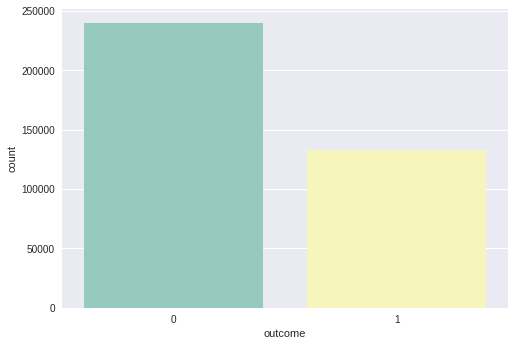

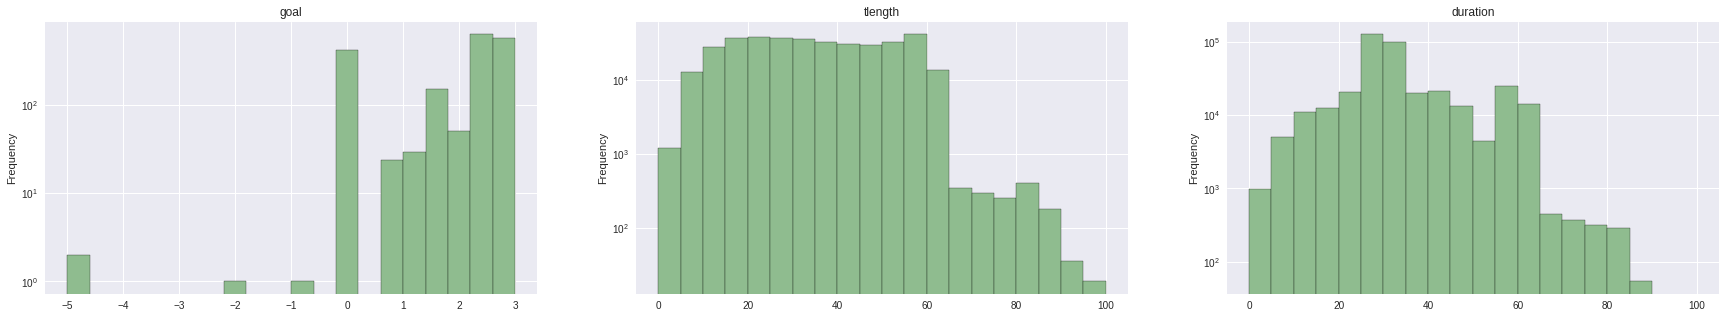

In [115]:
sns.countplot(x = 'outcome', data = ks, palette = 'Set3')


# FIND OUTLIERS
fig, axs = plt.subplots(ncols=3, figsize=(30,5))

# goal, kickstarter maximum is 100.000
axs[0].set_title("goal")
ks['goal'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[-5,3], ax=axs[0])

# tlength
axs[1].set_title("tlength")
ks['tlength'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,100], ax=axs[1])

# duration
axs[2].set_title("duration")
ks['duration'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,100], ax=axs[2])


plt.show()

In [116]:
# CATEGORICAL ENCODING (one-hot encoding, label encoding, count encoding, target encoding, catboost encoding)

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# categorical features to be encoded
features = ['category', 'currency', 'country', 'category_country']

# encoders
l_encoder = LabelEncoder() # label encoding, encode target labels with value between 0 and n_classes-1.
c_encoder = ce.CountEncoder() # count encoding, replaces each categorical value with the number of times it appears in the dataset
t_encoder = ce.TargetEncoder(cols=features) # target encoding, replaces a categorical value with the average value of the target for that value of the feature
cb_encoder = ce.CatBoostEncoder(cols=features) # catboost encoding, for each row, the target probability is calculated only from the rows before it

# encoded features
l_encoded = ks[features].apply(l_encoder.fit_transform)
c_encoded = c_encoder.fit_transform(ks[features])
t_encoded = t_encoder.fit_transform(ks[features], ks['outcome'])
cb_encoded = cb_encoder.fit_transform(ks[features], ks['outcome'])

# create data set
data = ks[['outcome', 'tlength', 'goal', 'duration', 'lyear', 'lmonth', 'lday', 'lhour', 'dyear', 'dmonth', 'dday', 'project_competition', 'category_competition']].join(t_encoded)

# print result
print(data.head(5))

   outcome  tlength       goal  duration  lyear  lmonth  lday  lhour  dyear  \
0        0       31   6.907755        58   2015       8     1     12   2015   
1        0       45  10.308953        60   2017       9     5      4   2017   
2        0       14  10.714418        45   2013       1     5      0   2013   
3        0       49   8.517193        30   2012       3     5      3   2012   
4        0       58   9.878170        56   2015       7     5      8   2015   

   dmonth  dday  project_competition  category_competition  category  \
0      10     4               1408.0             18.606111  0.359259   
1      11     2                956.0              5.592778  0.394179   
2       2     1                739.0              1.313611  0.394179   
3       4     0                907.0              0.635000  0.411590   
4       8     5               1429.0             16.661389  0.307443   

   currency   country  category_country  
0  0.356890  0.361387          0.460784  
1  0.373

In [117]:
# FEATURE SELECTION
from sklearn.tree import DecisionTreeClassifier

X = data.drop('outcome', axis = 1).values
y = data['outcome']
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(X,y)
fi_col = []
fi = []
for i,column in enumerate(data.drop('outcome', axis = 1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])
fi_col
fi
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
columns_to_keep = fi_df['Feature'][0:10]

print(fi_df)

# feature selection
#data = data[['outcome', 'category_country', 'goal', 'duration', 'project_competition', 'tlength', 'category']]

# correlations
#data.corr().abs()[['outcome']]


    index               Feature  Feature Importance
0      15      category_country            0.553970
1       1                  goal            0.213271
2       2              duration            0.079308
3      10   project_competition            0.035955
4       0               tlength            0.031589
5       6                 lhour            0.016710
6      11  category_competition            0.014734
7       3                 lyear            0.014259
8      12              category            0.014189
9       7                 dyear            0.007623
10      5                  lday            0.005099
11     14               country            0.004774
12      8                dmonth            0.003996
13      4                lmonth            0.001858
14      9                  dday            0.001519
15     13              currency            0.001147


In [118]:
# SCALE AND SPLIT DATA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# get predictors: goal, duration, project_competition, category, category_country
x_unscaled = data[['goal', 'duration', 'project_competition', 'category', 'category_country']]

# get outcome
y = data['outcome']

# feature scaling/normalizing
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x_unscaled), columns=list(x_unscaled.columns))

# split data into training, testing and validation set (60%, 20%, 20%)
# data -> training + testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# training -> training + cross validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

print("-"*35)
print("[60%] x_train:\t", x_train.shape[0])
print("[20%] x_valid:\t", x_valid.shape[0])
print("[20%] x_test:\t", x_test.shape[0])
print("-"*35)

# check if data is nicely spread
# https://imgur.com/a/cCCjKhj
# in the image above you see that the projects with outcome 1 are evenly spread among the sets

-----------------------------------
[60%] x_train:	 223836
[20%] x_valid:	 74613
[20%] x_test:	 74613
-----------------------------------


In [119]:
# LINEAR REGRESSION 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn import metrics

# create model
model = LogisticRegression()

# fit model on training data set
model.fit(x_train, y_train)

# test model on cross validation data set
y_pred_valid = model.predict(x_valid) 


# model score: score(test samples, true labels for x)
print("-"*60)
print("Logistic Regression Model Scores")
print('[TRAIN]\t %.2f%%' %(round(model.score(x_train, y_train),5)*100))
print('[VALID]\t %.2f%%' %(round(model.score(x_valid, y_valid),5)*100))
print('[TEST]\t %.2f%%' %(round(model.score(x_test, y_test),5)*100))
print("-"*60)

# classification report: classification_report(y_true, y_pred)
print("Classification Report")
print(classification_report(y_valid, y_pred_valid))
print("-"*60)


------------------------------------------------------------
Logistic Regression Model Scores
[TRAIN]	 69.73%
[VALID]	 69.67%
[TEST]	 69.64%
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.86      0.78     48070
           1       0.61      0.41      0.49     26543

    accuracy                           0.70     74613
   macro avg       0.67      0.63      0.64     74613
weighted avg       0.68      0.70      0.68     74613

------------------------------------------------------------


------------------------------------------------------------
[ACCURACY]	 69.67%
[PRECISION]	 60.96%
[RECALL]	 40.98%
------------------------------------------------------------


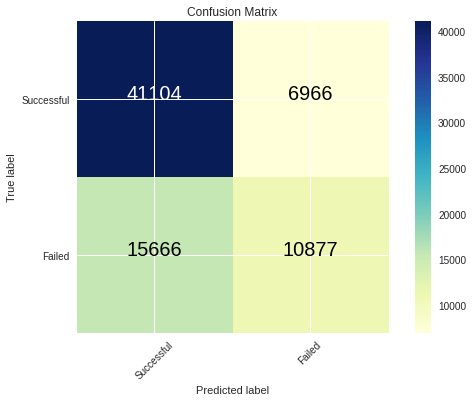

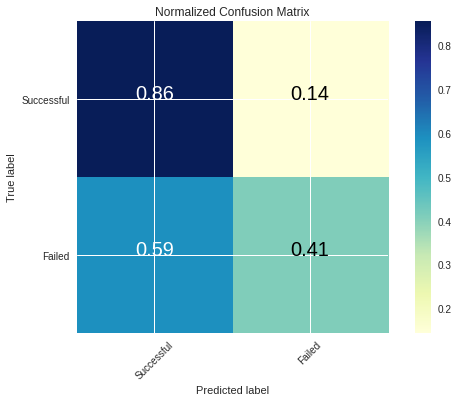

In [120]:
# CONFUSION MATRIX
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.YlGnBu):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            size="20")
           
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# confusion matrix: confusion_matrix(y_true, y_pred)
cnf_matrix = metrics.confusion_matrix(y_valid, y_pred_valid)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

# evaluation of confusion matrix
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_valid, y_pred_valid)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_valid, y_pred_valid)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_valid, y_pred_valid)*100))
print("-"*60)


The Log Loss on Training is:  0.5722447824669931
The Log Loss on Testing Dataset is:  0.5723480267936052
ROC Curve


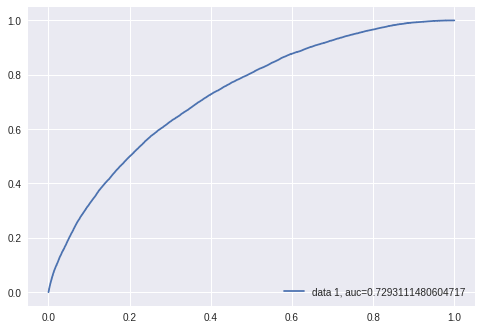

Test AUC score: 0.7293111480604717
------------------------------------------------------------


In [121]:
y_pred_proba_train = model.predict_proba(x_train) # training
y_pred_proba_test = model.predict_proba(x_test) # testing
y_pred_proba_valid = model.predict_proba(x_valid) # validation

# Running Log loss on training
print("The Log Loss on Training is: ", metrics.log_loss(y_train, y_pred_proba_train))
print("The Log Loss on Testing Dataset is: ", metrics.log_loss(y_test, y_pred_proba_test))

# RECEIVER OPERATING CHARACTERISTIC (ROC) CURVE: roc_curve(y_true, y_score)
print("ROC Curve")
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(f"Test AUC score: {auc}")
print("-"*60)




(0.68, 0.703)

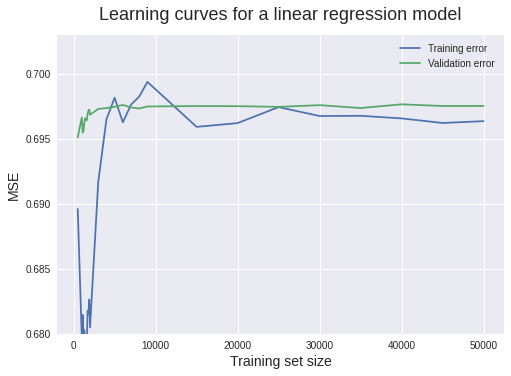

In [122]:

train_sizes, train_scores, validation_scores = learning_curve(estimator = LogisticRegression(), X=x_train, y=y_train, train_sizes = [500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 1000, 15000, 20000, 25000, 25000, 30000, 35000, 40000, 45000, 50000], cv = 5)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0.68,0.703)


The CA is: 0.6964201948722073
The Logistic Loss is:  0.5723481016852283
The optimal C parameter is:  [6.16]
The CA of C parameter 1e-05 is 0.6742390736198786:
The Logg Loss of C parameter 1e-05 is 0.5981102855776078:



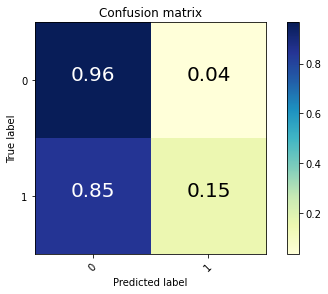

The CA of C parameter 3.359818286283781e-05 is 0.6925066677388659:
The Logg Loss of C parameter 3.359818286283781e-05 is 0.5811302724153283:



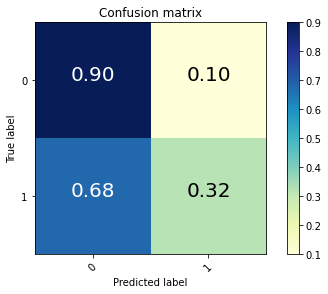

The CA of C parameter 0.00011288378916846884 is 0.6961521450685537:
The Logg Loss of C parameter 0.00011288378916846884 is 0.5750910641750291:



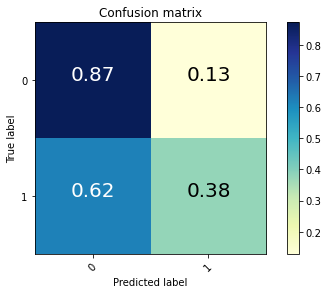

The CA of C parameter 0.000379269019073225 is 0.6957366678728908:
The Logg Loss of C parameter 0.000379269019073225 is 0.5732042067889652:



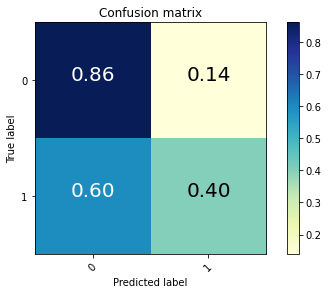

The CA of C parameter 0.0012742749857031334 is 0.6962593649900152:
The Logg Loss of C parameter 0.0012742749857031334 is 0.5725377478654836:



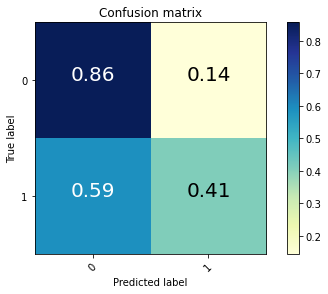

The CA of C parameter 0.004281332398719391 is 0.6962995724605632:
The Logg Loss of C parameter 0.004281332398719391 is 0.5723796220553452:



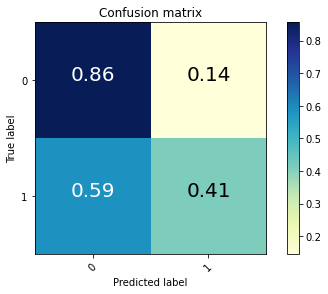

The CA of C parameter 0.01438449888287663 is 0.6962325600096498:
The Logg Loss of C parameter 0.01438449888287663 is 0.5723535997342715:



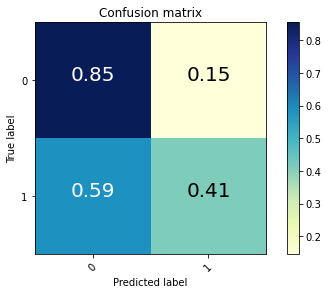

The CA of C parameter 0.04832930238571752 is 0.6962459624998325:
The Logg Loss of C parameter 0.04832930238571752 is 0.5723492446050449:



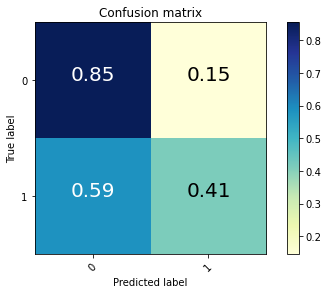

The CA of C parameter 0.1623776739188721 is 0.6963799874016592:
The Logg Loss of C parameter 0.1623776739188721 is 0.572348314140287:



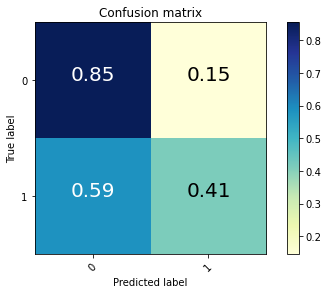

The CA of C parameter 0.5455594781168515 is 0.6964201948722073:
The Logg Loss of C parameter 0.5455594781168515 is 0.5723480716447317:



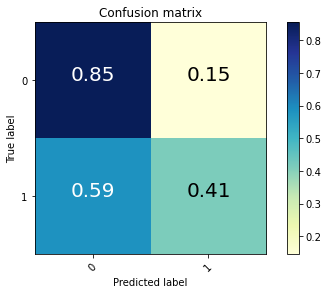

The CA of C parameter 1.8329807108324339 is 0.69643359736239:
The Logg Loss of C parameter 1.8329807108324339 is 0.5723480025774704:



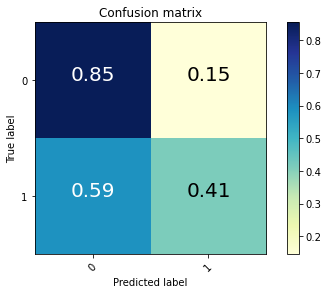

The CA of C parameter 6.1584821106602545 is 0.69643359736239:
The Logg Loss of C parameter 6.1584821106602545 is 0.5723479822974671:



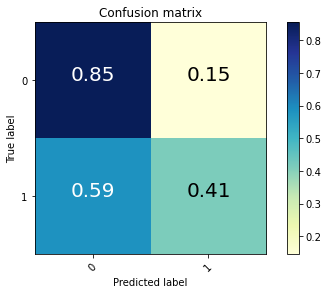

The CA of C parameter 20.6913808111479 is 0.6964201948722073:
The Logg Loss of C parameter 20.6913808111479 is 0.5723479762859902:



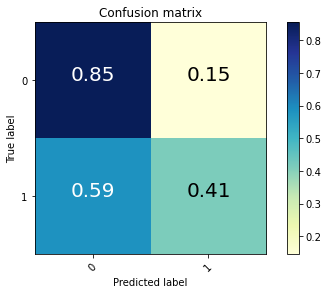

The CA of C parameter 69.51927961775606 is 0.6964201948722073:
The Logg Loss of C parameter 69.51927961775606 is 0.5723479744989406:



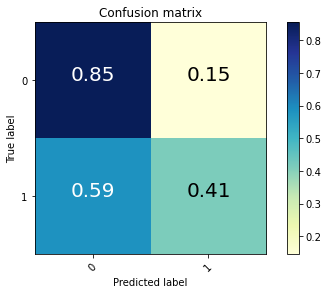

The CA of C parameter 233.57214690901213 is 0.6964201948722073:
The Logg Loss of C parameter 233.57214690901213 is 0.5723479739672447:



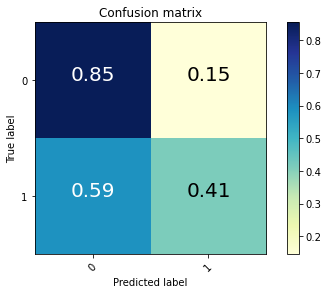

The CA of C parameter 784.7599703514607 is 0.6964201948722073:
The Logg Loss of C parameter 784.7599703514607 is 0.5723479738090104:



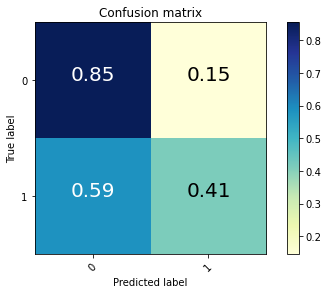

The CA of C parameter 2636.6508987303555 is 0.6964201948722073:
The Logg Loss of C parameter 2636.6508987303555 is 0.5723479737619158:



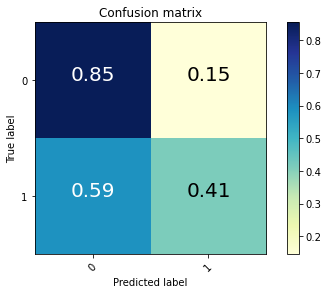

The CA of C parameter 8858.667904100832 is 0.6964201948722073:
The Logg Loss of C parameter 8858.667904100832 is 0.5723479737478987:



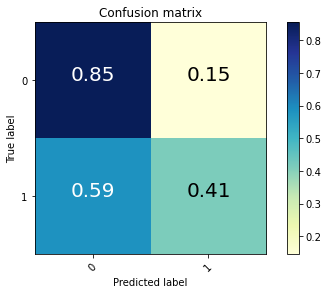

The CA of C parameter 29763.51441631313 is 0.6964201948722073:
The Logg Loss of C parameter 29763.51441631313 is 0.5723479737437271:



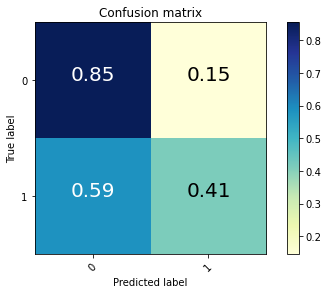

The CA of C parameter 100000.0 is 0.6964201948722073:
The Logg Loss of C parameter 100000.0 is 0.5723479737424854:



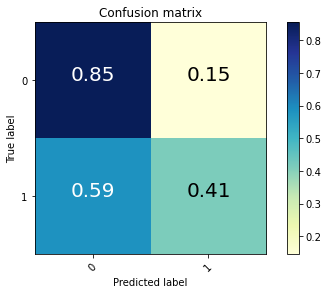

In [88]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, random_state=0, shuffle=True)

# Logistic Reg CV
Log_reg3 = LogisticRegressionCV(random_state=15, Cs = C_List, solver ='lbfgs')
Log_reg3.fit(x_train, y_train)
print("The CA is:", Log_reg3.score(x_test, y_test))
pred_proba_t = Log_reg3.predict_proba(x_test)
log_loss3 = metrics.log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_loss3)

print("The optimal C parameter is: ", Log_reg3.C_)


C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(x_train, y_train)
    score = log_reg2.score(x_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(x_test)
    log_loss2 = metrics.log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")
    
    y_pred = log_reg2.predict(x_train)
    cm = metrics.confusion_matrix(y_train, y_pred)
    #cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    plot_confusion_matrix(cm, normalize=True, classes = model.classes_, title='Confusion matrix', cmap=plt.cm.YlGnBu)
    plt.show()




In [ ]:
# LightGBM
# Tree-based model that typically provides the best performance, even compared to XGBoost. It's also relatively fast to train.

import lightgbm as lgb
from sklearn import metrics

feature_cols = train.columns.drop('outcome')

dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

# evaluation
print("-"*60)
print('Aread Under Curve (AUC): %.2f%%' %(metrics.roc_auc_score(test['outcome'], ypred)*100))
print("-"*60)

#76.06 (catboost)
#76.83 (target)
#76.34 (count)
#76.33 (label)


In [ ]:
# NAIVE BAYES ALGORITHM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn import metrics

# instantiate logistic regression model
model = GaussianNB()

# fit the model with the data
model.fit(x_train,y_train)

# make predictions
predict_test = model.predict(x_test)

# evaluation
print("-"*60)
print('Accuracy: %.2f%%' %(metrics.accuracy_score(y_test, predict_test)*100))
print('Precision: %.2f%%' %(metrics.precision_score(y_test, predict_test)*100))
print('Recall: %.2f%%' %(metrics.recall_score(y_test, predict_test)*100))
print("-"*60)


In [ ]:
# NEURAL NETWORK
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

#model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
#model.fit(x_train, y_train, batch_size=32, epochs=50)

#model.summary()

#y_pred = model.predict_classes(x_test)
#print(metrics.accuracy_score(y_test, y_pred))

